# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [9]:
def build_custom_model(audio_features,
                       learning_rate=0.00005,
                       dropout_rate=0.3,
                       conv_layers_config=[(64, (3, 3)), (32, (5, 5)), (32, (3, 3))],
                       dense_units=[512],
                       num_classes=20,
                       dropout_fc=0.3,
                       kernel_regularizer_val=0.15):
    """
    Build a customizable CNN model for audio classification.

    Parameters:
    - audio_features: Shape of the input audio features (e.g., mel spectrograms).
    - learning_rate: Learning rate for the optimizer.
    - dropout_rate: Dropout rate for convolutional layers.
    - conv_layers_config: List of tuples where each tuple contains (number of filters, kernel size).
    - dense_units: List containing the number of units in fully connected layers.
    - num_classes: Number of output classes for classification.
    - dropout_fc: Dropout rate for fully connected layers.
    - kernel_regularizer_val: L2 regularization value for Conv2D layers.

    Returns:
    - Compiled Keras model.
    """

    tf.keras.backend.clear_session()

    # Input layer
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]), name='Audio_Features')

    features = inputs
    # Add customizable convolutional layers
    for i, (filters, kernel_size) in enumerate(conv_layers_config):
        features = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=(1, 1),
            padding='same',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer_val),
            name=f'conv_{i+1}'
        )(features)

        features = tf.keras.layers.MaxPool2D(pool_size=(2, 2), name=f'pool_{i+1}')(features)
        if dropout_rate > 0:
            features = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout_conv_{i+1}')(features)

    features = tf.keras.layers.BatchNormalization()(features)

    # Flatten the features
    features = tf.keras.layers.Flatten()(features)

    # Add fully connected layers
    for j, units in enumerate(dense_units):
        features = tf.keras.layers.Dense(units=units, activation='relu', name=f'fc_{j+1}')(features)


    # Output layer
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='output')(features)

    # Build the model
    model = tf.keras.Model(inputs=[inputs], outputs=outputs, name='Birds_Custom_Model')

    print(model.summary())

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
def build_and_train_models(model_configs, train_features, train_y, val_features, val_y, train_results, val_results, val_scores, epochs=100, batch_size=32):
    """
    Build, train, and evaluate multiple models based on configurations provided in model_configs.

    Parameters:
    - model_configs: Dictionary where each key is a model name and the value is a config dictionary for that model.
    - train_features: Training features (e.g., mel spectrograms + MFCC).
    - train_y: Training labels.
    - val_features: Validation features (e.g., mel spectrograms + MFCC).
    - val_y: Validation labels.
    - train_results: Dictionary to store training results (e.g., accuracy).
    - val_results: Dictionary to store validation results (e.g., accuracy).
    - val_scores: Dictionary to store validation metrics like precision, recall, etc.
    - epochs: Number of epochs to train each model.
    - batch_size: Batch size for training.

    Returns:
    - None (modifies train_results, val_results, and val_scores in place).
    """

    for model_name, config in model_configs.items():
        print(f"Building and training {model_name}...")

        # Unpack the configuration for each model
        learning_rate = config.get('learning_rate')
        dropout_rate = config.get('dropout_rate')
        conv_layers_config = config.get('conv_layers')
        dense_units = config.get('dense_units')
        dropout_fc = config.get('dropout_fc')
        num_classes = config.get('num_classes')
        kernel_regularizer_val = config.get('kernel_regularizer_val')

        # Build the model
        model = build_custom_model(
            audio_features=train_features,
            learning_rate=learning_rate,
            dropout_rate=dropout_rate,
            conv_layers_config=conv_layers_config,
            dense_units=dense_units,
            num_classes=num_classes,
            dropout_fc=dropout_fc,
            kernel_regularizer_val=kernel_regularizer_val
        )

        # Train the model
        history = model.fit(
            x=train_features,
            y=train_y,
            epochs=epochs,
            validation_data=(val_features, val_y),
            batch_size=batch_size,
            verbose=1
        )

        # Visualize training history
        visualize(history, model_name)

        # Evaluate model on training data
        train_yhat = model.predict(train_features)
        train_yhat_result = np.argmax(train_yhat, axis=-1)
        train_results[model_name] = model.evaluate(train_features, train_y)[-1]

        # Evaluate model on validation data
        val_yhat = model.predict(val_features)
        val_yhat_result = np.argmax(val_yhat, axis=-1)
        val_results[model_name] = model.evaluate(val_features, val_y)[-1]

        # Store validation scores (like accuracy, precision, recall, etc.)
        val_scores[model_name] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

        print(f"Completed training and evaluation for {model_name}.\n")

In [14]:
model_configs = {
    'model_1': {
        'learning_rate': 0.00005,
        'dropout_rate': 0.3,
        'conv_layers': [(64, (3, 3)), (32, (3, 3))],
        'dense_units': [256],
        'dropout_fc': 0,
        'num_classes': 20,
        'kernel_regularizer_val': 0.15
    },
    'model_2': {
        'learning_rate': 0.0004,   # Slightly reduced learning rate
        'dropout_rate': 0.4,
        'conv_layers': [(64, (5, 5)), (32, (5, 5)), (32, (5, 5))],
        'dense_units': [256, 128],
        'dropout_fc': 0.1,
        'num_classes': 20,
        'kernel_regularizer_val': 0.25
    },
    'model_3': {
        'learning_rate': 0.0001,
        'dropout_rate': 0.3,
        'conv_layers': [(32, (5, 5)), (32, (5, 5))],
        'dense_units': [128],
        'dropout_fc': 0.2,  # Increase dropout to handle overfitting
        'num_classes': 20,
        'kernel_regularizer_val': 0.2
    },
    'model_4': {
        'learning_rate': 0.00002,
        'dropout_rate': 0.25,
        'conv_layers': [(64, (5, 5)), (32, (5, 5)), (32, (5, 5))],
        'dense_units': [256, 64],
        'dropout_fc': 0.3,
        'num_classes': 20,
        'kernel_regularizer_val': 0.05
    },
    'model_5': {
        'learning_rate': 0.0003,
        'dropout_rate': 0.5,
        'conv_layers': [(64, (5, 5)), (32, (5, 5)), (16, (5, 5))],
        'dense_units': [256, 128],
        'dropout_fc': 0.2,
        'num_classes': 20,
        'kernel_regularizer_val': 0.3
    }
}


In [15]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram

In [16]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 2)


In [17]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 2)


Building and training model_1...


Model: "Birds_Custom_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_1 (Dropout)             │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_2 (Dropout)             │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,802,420 (64.10 MB)

 Trainable params: 16,802,356 (64.10 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.2384 - loss: 9.2174 - val_accuracy: 0.1644 - val_loss: 8.4346
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4628 - loss: 7.2570 - val_accuracy: 0.1163 - val_loss: 8.6570
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5579 - loss: 6.0370 - val_accuracy: 0.1148 - val_loss: 10.1427
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6173 - loss: 5.1197 - val_accuracy: 0.1044 - val_loss: 12.5460
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7045 - loss: 4.2682 - val_accuracy: 0.1089 - val_loss: 11.9332
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7487 - loss: 3.6540 - val_accuracy: 0.1415 - val_loss: 9.4925
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7754 - loss: 3.1604 - val_accuracy: 0.1422 - val_loss: 8.9741
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8290 - loss: 

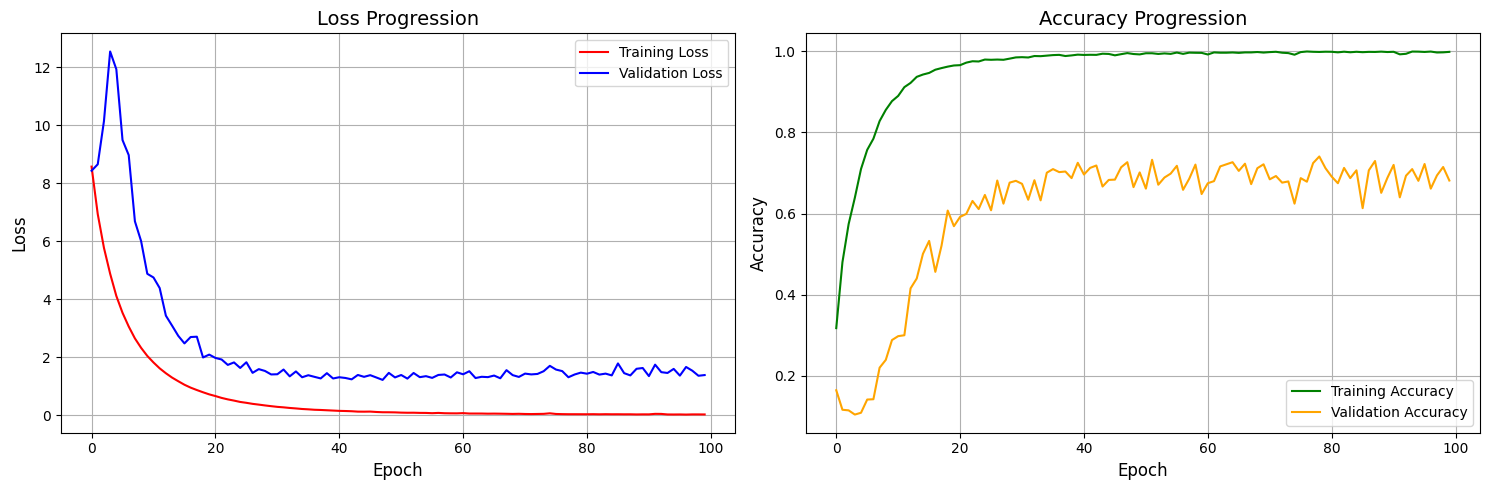

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 0.0300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6829 - loss: 1.3561
Validation classification Report 

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       114
           1       0.39      0.55      0.46       141
           2       0.71      0.54      0.61       271
           3       0.90      1.00      0.95        90
           4       1.00      0.11      0.20        18
           5       0.67      0.53      0.59        15
           6       0.28      0.61      0.38        23
           7       0.98      0.98      0.98        44
           8       0.49      0.72      0.59        50
           9       0.72      0.96      0.82        49
          10       0.78      0.44      0.56        48
          11       0.79      0.57      0.66        46
          12       0.80      0.

Model: "Birds_Custom_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_1 (Dropout)             │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_2 (Dropout)             │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_3 (Dropout)             │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,310,292 (16.44 MB)

 Trainable params: 4,310,228 (16.44 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.2277 - loss: 14.4346 - val_accuracy: 0.1044 - val_loss: 4.6326
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5261 - loss: 2.4950 - val_accuracy: 0.1222 - val_loss: 2.8990
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6754 - loss: 1.2526 - val_accuracy: 0.1822 - val_loss: 2.6074
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8020 - loss: 0.8370 - val_accuracy: 0.5333 - val_loss: 1.5549
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8537 - loss: 0.6345 - val_accuracy: 0.5385 - val_loss: 1.5173
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8726 - loss: 0.5462 - val_accuracy: 0.6689 - val_loss: 1.2766
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8935 - loss: 0.5002 - val_accuracy: 0.6770 - val_loss: 1.1875
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9169 - loss: 0

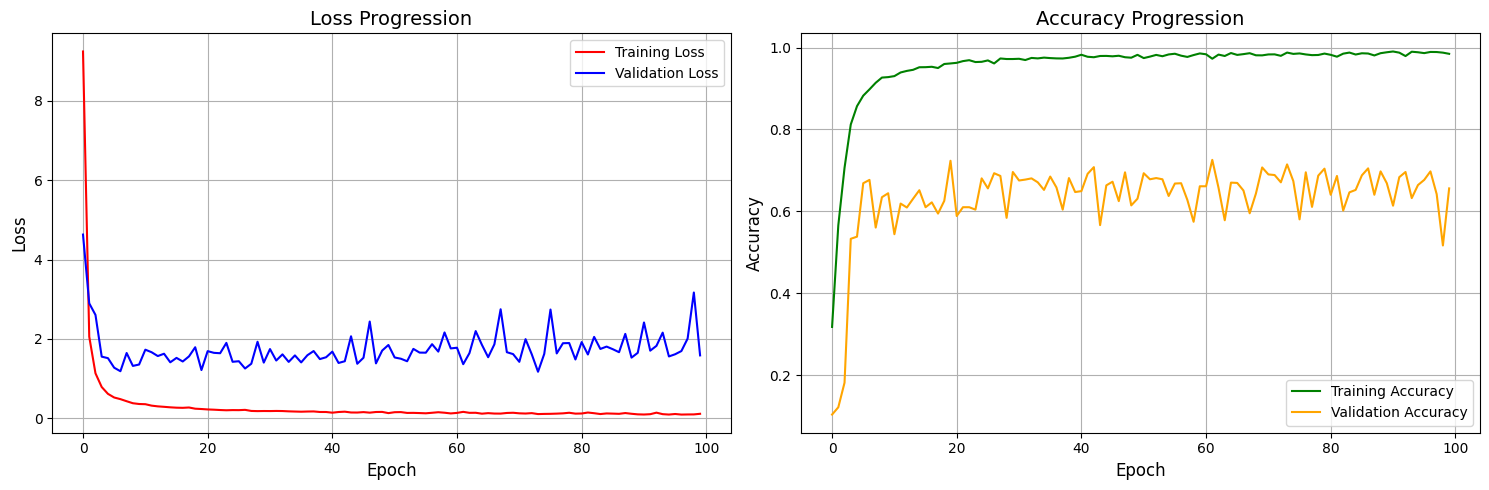

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9965 - loss: 0.1004
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6453 - loss: 1.5966
Validation classification Report 

              precision    recall  f1-score   support

           0       0.90      0.83      0.87       114
           1       0.34      0.59      0.43       141
           2       0.64      0.43      0.51       271
           3       0.94      1.00      0.97        90
           4       1.00      0.39      0.56        18
           5       0.10      0.07      0.08        15
           6       0.23      0.65      0.34        23
           7       1.00      1.00      1.00        44
           8       0.39      0.72      0.51        50
           9       0.89      0.98      0.93        49
          10       0.77      0.48      0.59        48
          11       0.60      0.57      0.58        46
          12       0.87      0

Model: "Birds_Custom_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 32)        │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_1 (Dropout)             │ (None, 64, 129, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_2 (Dropout)             │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,418,708 (32.11 MB)

 Trainable params: 8,418,644 (32.11 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.2903 - loss: 8.6475 - val_accuracy: 0.1096 - val_loss: 7.0231
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5816 - loss: 5.1664 - val_accuracy: 0.1044 - val_loss: 7.0325
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7249 - loss: 3.4015 - val_accuracy: 0.1044 - val_loss: 5.8002
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8144 - loss: 2.4270 - val_accuracy: 0.1533 - val_loss: 5.0673
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8715 - loss: 1.7881 - val_accuracy: 0.1637 - val_loss: 4.9268
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9017 - loss: 1.3978 - val_accuracy: 0.4704 - val_loss: 2.5757
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9270 - loss: 1.1195 - val_accuracy: 0.3104 - val_loss: 3.4762
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9456 - loss: 0.8

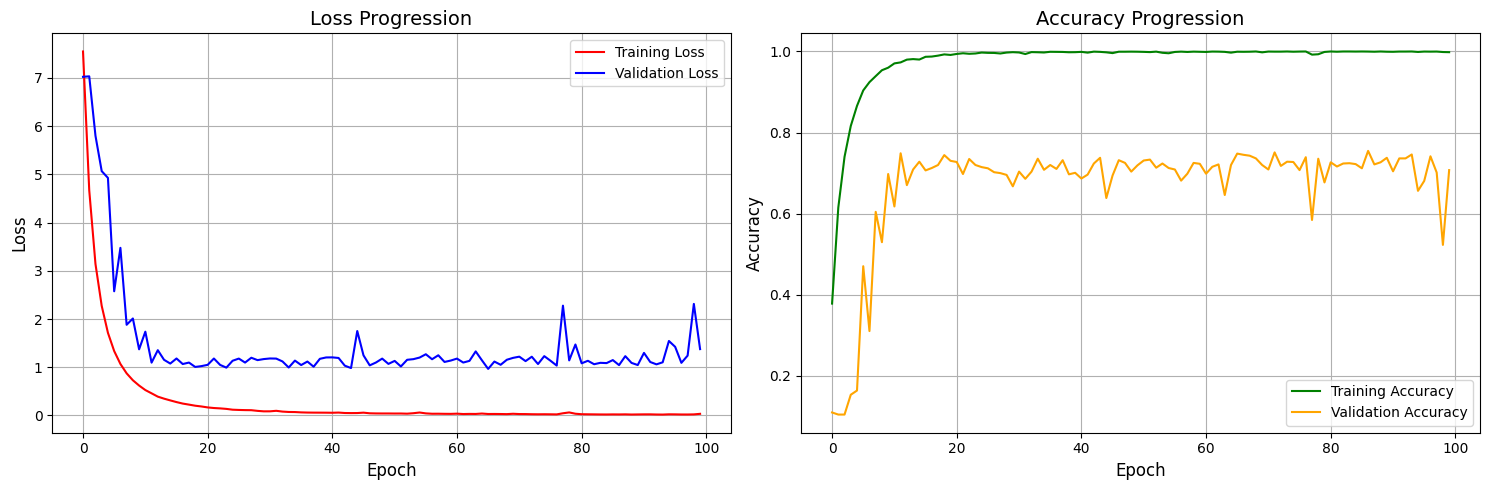

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 0.0261
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7170 - loss: 1.3885
Validation classification Report 

              precision    recall  f1-score   support

           0       0.70      0.92      0.79       114
           1       0.44      0.61      0.51       141
           2       0.83      0.62      0.71       271
           3       0.90      1.00      0.95        90
           4       1.00      0.61      0.76        18
           5       0.46      0.40      0.43        15
           6       0.24      0.43      0.31        23
           7       1.00      1.00      1.00        44
           8       0.70      0.62      0.66        50
           9       0.98      0.88      0.92        49
          10       0.81      0.81      0.81        48
          11       0.76      0.48      0.59        46
          12       0.71      0.

Model: "Birds_Custom_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_1 (Dropout)             │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_2 (Dropout)             │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_3 (Dropout)             │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,292,564 (16.37 MB)

 Trainable params: 4,292,500 (16.37 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.1118 - loss: 6.8776 - val_accuracy: 0.1044 - val_loss: 6.5930
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.1845 - loss: 6.1592 - val_accuracy: 0.1044 - val_loss: 6.4046
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2502 - loss: 5.7240 - val_accuracy: 0.1044 - val_loss: 6.8024
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3338 - loss: 5.2603 - val_accuracy: 0.1111 - val_loss: 6.9257
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4118 - loss: 4.8257 - val_accuracy: 0.1119 - val_loss: 6.7936
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4729 - loss: 4.4948 - val_accuracy: 0.1133 - val_loss: 6.6761
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5301 - loss: 4.1720 - val_accuracy: 0.1126 - val_loss: 6.3987
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5821 - loss: 3.9

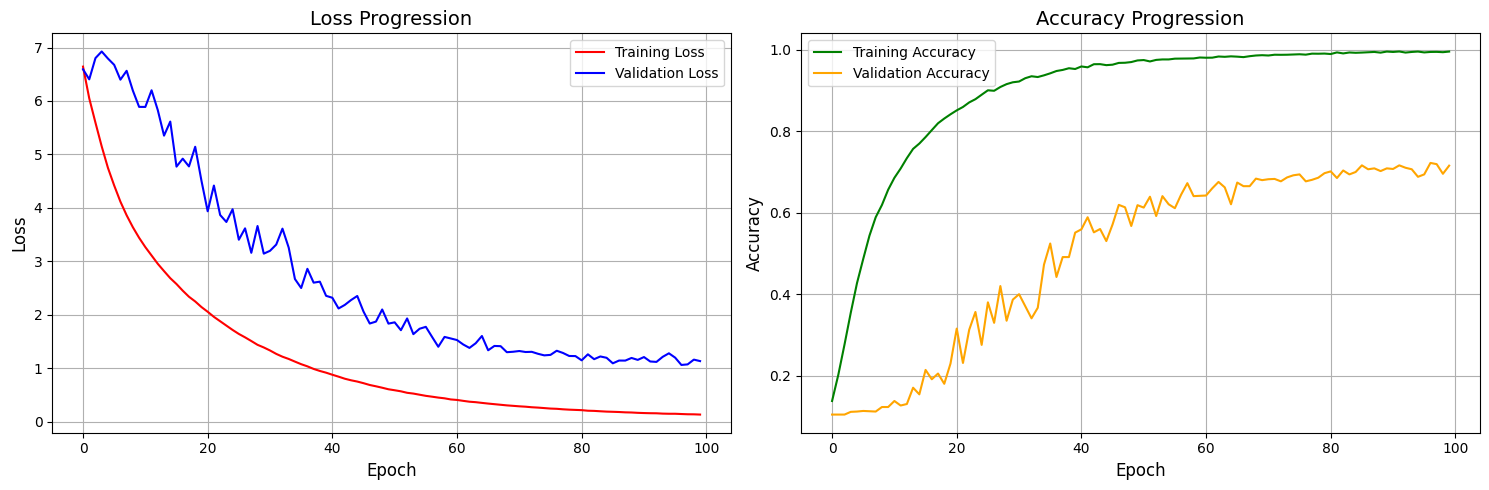

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9986 - loss: 0.1232
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7100 - loss: 1.1462
Validation classification Report 

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       114
           1       0.46      0.55      0.50       141
           2       0.73      0.63      0.68       271
           3       0.88      1.00      0.94        90
           4       1.00      0.06      0.11        18
           5       0.30      0.20      0.24        15
           6       0.24      0.57      0.34        23
           7       1.00      1.00      1.00        44
           8       0.82      0.62      0.70        50
           9       0.81      0.94      0.87        49
          10       0.87      0.71      0.78        48
          11       0.74      0.43      0.55        46
          12       0.75      0

Model: "Birds_Custom_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_1 (Dropout)             │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_2 (Dropout)             │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 16)          │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_conv_3 (Dropout)             │ (None, 16, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,200,260 (8.39 MB)

 Trainable params: 2,200,228 (8.39 MB)

 Non-trainable params: 32 (128.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.1556 - loss: 16.2194 - val_accuracy: 0.1044 - val_loss: 6.4231
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4170 - loss: 3.7154 - val_accuracy: 0.1148 - val_loss: 3.7844
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5434 - loss: 1.8544 - val_accuracy: 0.2000 - val_loss: 2.4384
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6540 - loss: 1.2884 - val_accuracy: 0.2600 - val_loss: 2.3408
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7197 - loss: 1.0298 - val_accuracy: 0.2252 - val_loss: 3.1185
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7778 - loss: 0.8824 - val_accuracy: 0.4378 - val_loss: 1.8973
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7971 - loss: 0.7674 - val_accuracy: 0.6422 - val_loss: 1.2726
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8341 - loss: 0

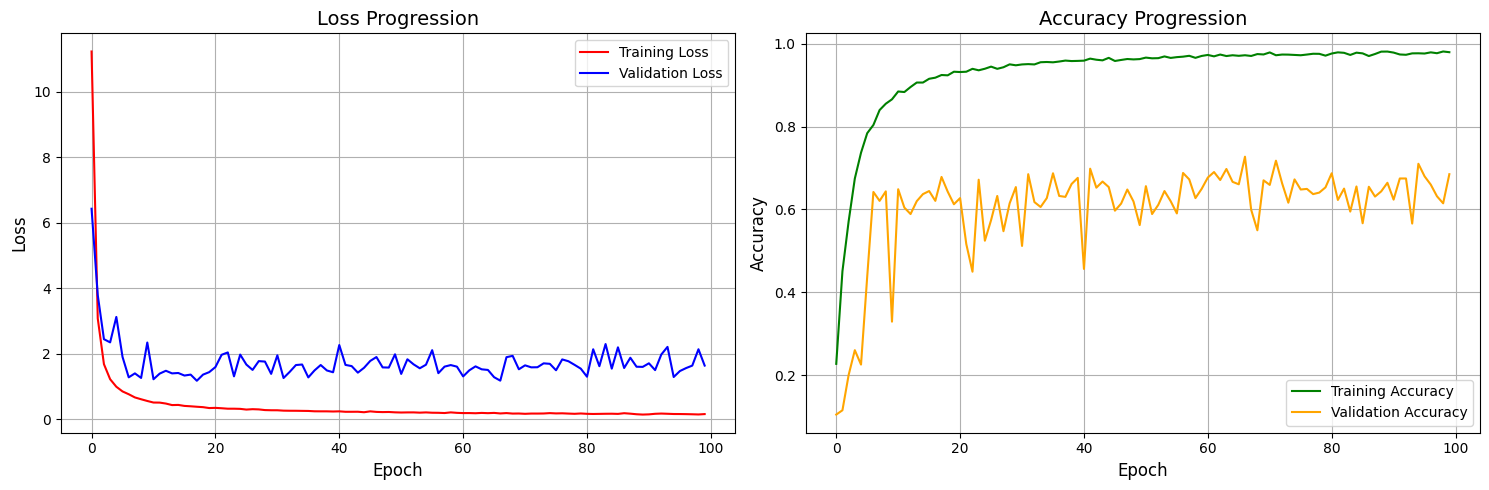

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9850 - loss: 0.1164
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6831 - loss: 1.7141
Validation classification Report 

              precision    recall  f1-score   support

           0       0.83      0.71      0.76       114
           1       0.41      0.38      0.39       141
           2       0.73      0.69      0.71       271
           3       0.90      1.00      0.95        90
           4       0.43      0.17      0.24        18
           5       0.10      0.07      0.08        15
           6       0.17      0.22      0.19        23
           7       0.98      1.00      0.99        44
           8       0.62      0.60      0.61        50
           9       0.77      0.90      0.83        49
          10       0.84      0.65      0.73        48
          11       0.45      0.59      0.51        46
          12       0.80      0

In [18]:
# Build, train, and evaluate models
build_and_train_models(
    model_configs=model_configs,
    train_features=training_features,
    train_y=train_y,
    val_features=validation_features,
    val_y=val_y,
    train_results=train_results,
    val_results=val_results,
    val_scores=val_scores,
    epochs=100,
    batch_size=32
)

## Review all the results

In [19]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,model_1,1.000,0.681
1,model_2,0.996,0.656
2,model_3,1.000,0.707
3,model_4,0.998,0.716
4,model_5,0.986,0.685


In [20]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

  Features  F1_Score  AUC_Score
0  model_1     0.682      0.956
1  model_2     0.664      0.961
2  model_3     0.704      0.971
3  model_4     0.714      0.970
4  model_5     0.683      0.960
